# 対話的な実験 with Azure ML

ノートブック上でアドホックに分析・機械学習を進める場合の Azure ML の使用方法

  ![images/interactive.png](images/interactive.png)
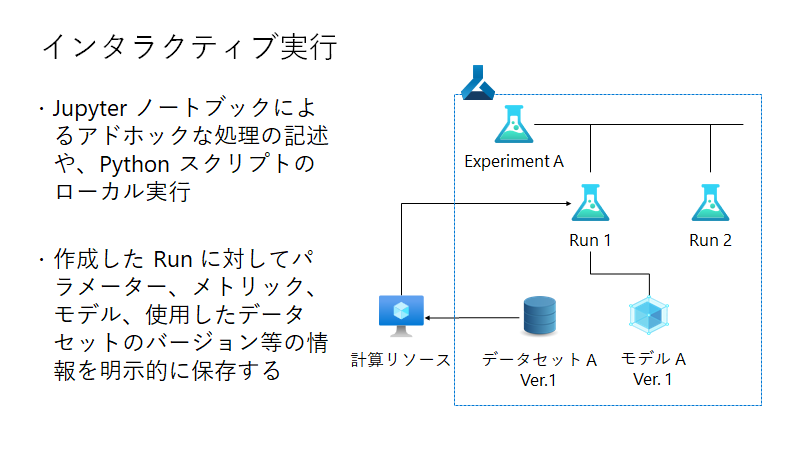

## ライブラリのインポート

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd
import lightgbm as lgb

from azureml.core import Workspace, Datastore, Dataset
from azureml.opendatasets import NycTlcGreen
import mlflow

import time
import cloudpickle
import copy
from datetime import datetime
from dateutil.relativedelta import relativedelta

## Azure ML Workspace 接続

認証方法は

- インタラクティブ認証
- サービスプリンシパル認証
- マネージド ID 認証

の3通りが使用可能。

Compute Instance から使用する場合は特に設定不要で

```
ws = Workspace.from_config()
```

のみで Workspace インスタンスの取得と認証が可能。

DSVM の場合は3通りのいずれかが使用可能だが、無人実行でない限りはユーザーを特定した方がセキュリティ上好ましいため、インタラクティブ認証が望ましい。以前 Azure CLI で認証を通した環境の場合、サービスプリンシパル認証として認証が通ることがある点に注意。

In [ ]:
subscription_id = "<id>" # 環境ごとに変更
resource_group = '<rg>' # 環境ごとに変更
workspace_name = '<ws>' # 環境ごとに変更

# 指定した Azure ML Workspace と紐づく Workspace インスタンスを作成
ws = Workspace(
        workspace_name=workspace_name,
        subscription_id=subscription_id,
        resource_group=resource_group,
    )

## Azure ML の MLflow エンドポイントへの接続

Azure ML が備える MLflow エンドポイント URI を取得し、MLflow にセットする。

azureml-mlflow パッケージのインストール必須

https://docs.microsoft.com/ja-jp/azure/machine-learning/how-to-use-mlflow

In [ ]:
mlflow_uri = ws.get_mlflow_tracking_uri()
mlflow.set_tracking_uri(mlflow_uri)

## データセットの取得orデータセットの加工・登録

Azure ML に既に nyc_taxi_dataset が登録済みであった場合は取得して pandas データフレームとして読み込む。登録されていない場合は Azure ML Opendatasets からオリジナルのデータセットを取得し、加工した上で Azure ML に Dataset として登録する。

In [ ]:
dataset_name = "nyc_taxi_dataset"

try:
    # 指定したデータセット名称を持つ Dataset と紐づく Dataset インスタンスを作成
    dataset = Dataset.get_by_name(ws, dataset_name)
    # pandas データフレームとして読み込み
    df = dataset.to_pandas_dataframe()
    
except:
    raw_df = pd.DataFrame([])
    start = datetime.strptime("1/1/2015","%m/%d/%Y")
    end = datetime.strptime("1/31/2015","%m/%d/%Y")
    # Azure ML Opendatasets からデータセットを取得
    for sample_month in range(3):
        temp_df_green = NycTlcGreen(start + relativedelta(months=sample_month), end + relativedelta(months=sample_month)) \
            .to_pandas_dataframe()
        raw_df = raw_df.append(temp_df_green.sample(2000))
    
    raw_df.head(10)
    
    df = copy.deepcopy(raw_df)
    
    # 加工
    columns_to_remove = ["lpepDropoffDatetime", "puLocationId", "doLocationId", "extra", "mtaTax",
                         "improvementSurcharge", "tollsAmount", "ehailFee", "tripType", "rateCodeID",
                         "storeAndFwdFlag", "paymentType", "fareAmount", "tipAmount"
                        ]
    for col in columns_to_remove:
        df.pop(col)  
    
    df = df.query("pickupLatitude>=40.53 and pickupLatitude<=40.88")
    df = df.query("pickupLongitude>=-74.09 and pickupLongitude<=-73.72")
    df = df.query("tripDistance>=0.25 and tripDistance<31")
    df = df.query("passengerCount>0 and totalAmount>0")
    
    df["lpepPickupDatetime"] = df["lpepPickupDatetime"].map(lambda x: x.timestamp())
    
    # デフォルトの Datastore と紐づく Datastore インスタンスを作成
    datastore = Datastore.get_default(ws)
    # Azure ML 上の Dataset として加工した pandas データフレームを登録
    dataset = Dataset.Tabular.register_pandas_dataframe(df, datastore, dataset_name)
        
df.head(5)

## LightGBM 向けのデータセット準備

In [ ]:
# データセット分割
train, test = train_test_split(df, test_size=0.2, random_state=1234)

# 説明変数と目的変数に分割
x_train = train[train.columns[train.columns != 'totalAmount']]
y_train = train['totalAmount']

x_test = test[test.columns[test.columns != 'totalAmount']]
y_test = test['totalAmount']

In [ ]:
# LightGBM の学習に使用する Dataset 形式に変換
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

## 実験記録準備

Azure ML の Experiment、Run、Model は MLflow と互換性を持つ。MLflow の方が API の命名規則に一貫性があり使いやすいため、実験記録部分に関してのみ Azure ML SDK ではなく MLflow を使用する。

MLflow の場合、対応している有名アルゴリズムの場合は autolog により半自動でメトリックを取得することも可能。

mlflow.lightgbm: https://www.mlflow.org/docs/latest/python_api/mlflow.lightgbm.html

MLflow API: https://www.mlflow.org/docs/latest/python_api/mlflow.html#

In [ ]:
# Experiment を作成
experiment_name = "interactive_nyc_taxi_lightgbm_regression"
mlflow.set_experiment(experiment_name)

# Experiment の詳細を確認する場合は expriment を取得して中身を展開する
#experiment = mlflow.get_experiment_by_name(experiment_name)

# Azure ML Experiment クラスからインスタンスを作成することと等価
#experiment = Experiment(ws, experiment_name)

## 実験

In [ ]:
# Run を作成、開始する
run_name = f'lightgbm_run_{int(time.time())}'
run = mlflow.start_run(run_name=run_name)
# Azure ML Experiment の start_logging 関数から Run インスタンスを作成することと等価
#run = experiment.start_logging(ws, display_name)

In [ ]:
# LightGBM にセットするパラメーターを定義
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'num_leaves': 10,
    'min_data_in_leaf': 1,
    'num_iteration': 100,
    'verbose': 0
}
# Run に記録
mlflow.log_params(params)
# Azure ML SDK の以下と大体等価ではあるが、厳密には一致していない
#run.add_properties(params)

In [ ]:
# 学習を実行
gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=50,
    valid_sets=lgb_eval,
    early_stopping_rounds=10
)

In [ ]:
# 作成したモデルをファイルに保存
model_path = 'outputs/model.pickle'
save_dir = 'outputs'
with open(model_path, mode='wb') as f:
    cloudpickle.dump(gbm, f)
# Run に記録
mlflow.log_artifact(model_path, save_dir)
# Azure ML SDK の以下と等価
#run.upload_file(model_path, model_path)

In [ ]:
# テストデータによって推論を実行
y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)

In [ ]:
# テストスコア (R2) を計算
test_score = r2_score(y_test, y_pred)
print(test_score)
# Run に記録
mlflow.log_metric('r2', test_score)
# Azure ML SDK の以下と等価
#run.log('r2', test_score)

In [ ]:
# テストスコア (RMSE) を計算
test_RMSE_score = np.sqrt(mean_squared_error(y_test, y_pred))
print(test_RMSE_score)
# Run に記録
mlflow.log_metric('rmse', test_RMSE_score)

In [ ]:
# Run を終了する
mlflow.end_run()

# 以下と等価
# run.complete()

In [ ]:
# Run に登録したモデルを Model として Azure ML に登録する
model_name = "nyc_taxi_lightgbm_regression_model"
mlflow.register_model(run.info.artifact_uri+"/"+model_path, model_name)